In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision
from tqdm import tqdm
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from torchvision.datasets import ImageFolder

# 导入cifar10

In [22]:

# ----------
# 1. 数据增强 / 预处理
# CIFAR10 是 3 通道，Normalize 传长度 3 的 tuple
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# ----------
# 2. 加载 CIFAR10
# 假设你的目录结构是：
# /path/to/project/
#   └── robot/
#       └── cifar-10-batches-py/
#            ├── data_batch_1
#            ├── ...
#            └── test_batch
cifar_root = '/Users/jinzi/Coding/PycharmProject/robot'   # ← 改成你机器上真正的路径

trainset = torchvision.datasets.CIFAR10(
    root=cifar_root,
    train=True,
    download=False,
    transform=transform_train
)
testset = torchvision.datasets.CIFAR10(
    root=cifar_root,
    train=False,
    download=False,
    transform=transform_test
)

# ----------
# 3. 划分 train / val
val_size   = 5000
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))

# ----------
# 4. DataLoader
trainloader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2)
valloader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2)
testloader  = DataLoader(testset,  batch_size=128, shuffle=False, num_workers=2)

print("Train batches:", len(trainloader))
print("Val   batches:", len(valloader))
print("Test  batches:", len(testloader))

Train batches: 352
Val   batches: 40
Test  batches: 79


In [23]:
print("CIFAR-10 训练集样本数:", len(train_ds))    # 剩余 45000 张
print("CIFAR-10 验证集样本数:", len(val_ds))      # 留出的 5000 张
print("CIFAR-10 测试集样本数:", len(testset))    # 全量 10000 张

CIFAR-10 训练集样本数: 45000
CIFAR-10 验证集样本数: 5000
CIFAR-10 测试集样本数: 10000


# 导入icub


In [2]:
# 2.1 定义 iCub 的数据增强和预处理
transform_icub_train = transforms.Compose([
    transforms.Resize((160,160)),        # iCub 裁剪后是 160×160
    transforms.RandomHorizontalFlip(),   # 人演示时也会有左右翻
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],   # ImageNet 常用归一化
                         std =[0.229,0.224,0.225])
])
transform_icub_test = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

# 2.2 全训练集（human-mode）——用 ImageFolder 自动递归搜 class 子目录
icub_train_root = './iCubWorld/train'
icub_full_train = ImageFolder(root=icub_train_root, transform=transform_icub_train)
print(f"Found {len(icub_full_train)} human-mode training images across {len(icub_full_train.classes)} classes.")

# 2.3 划分 train / val（这里 80/20 随机分）
val_ratio = 0.2
train_size = int((1 - val_ratio) * len(icub_full_train))
val_size   = len(icub_full_train) - train_size
icub_train_ds, icub_val_ds = random_split(
    icub_full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# 2.4 categorization 测试集 —— 用同样的 class 标签
icub_test_root = './iCubWorld/test/categorization'
icub_test_ds = ImageFolder(root=icub_test_root, transform=transform_icub_test)
print(f"Found {len(icub_test_ds)} categorization-test images.")

# 2.5 构建 DataLoader
icub_train_loader = DataLoader(icub_train_ds, batch_size=32, shuffle=True,  num_workers=2)
icub_val_loader   = DataLoader(icub_val_ds,   batch_size=32, shuffle=False, num_workers=2)
icub_test_loader  = DataLoader(icub_test_ds,  batch_size=32, shuffle=False, num_workers=2)

print("iCubWorld → train:", len(icub_train_ds),
      "val:",   len(icub_val_ds),
      "test:",  len(icub_test_ds))

Found 6002 human-mode training images across 10 classes.
Found 2001 categorization-test images.
iCubWorld → train: 4801 val: 1201 test: 2001


# CNN定义

In [9]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super(ImprovedCNN, self).__init__()
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        # GAP + Dropout + FC
        self.gap = nn.AdaptiveAvgPool2d((1,1))  # (N,128,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),               # (N,128)
            nn.Dropout(dropout),        # <--- 用可调 dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)  # → (N,32,16,16)
        x = self.block2(x)  # → (N,64,8,8)
        x = self.block3(x)  # → (N,128,4,4)
        x = self.gap(x)     # → (N,128,1,1)
        return self.classifier(x)  # → (N,num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # 使用时就可以传 dropout 了
# model = ImprovedCNN(dropout=0.5).to(device)


In [41]:
model = ImprovedCNN(dropout=0.5).to(device)
sum(p.numel() for p in model.parameters() if p.requires_grad)

288746

# train函数

In [27]:
# def train_model(n_epoch, train_loader, val_loader):
#     history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
#     for epoch in range(n_epoch):
#         # ———— 训练 ————
#         model.train()
#         running_loss, correct, total = 0.0, 0, 0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
# 
#             running_loss += loss.item()
#             _, preds = outputs.max(1)
#             correct += preds.eq(labels).sum().item()
#             total   += labels.size(0)
# 
#         # ———— 验证 ————
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 _, preds = outputs.max(1)
#                 val_correct += preds.eq(labels).sum().item()
#                 val_total   += labels.size(0)
# 
#         # 记录并打印
#         epoch_loss = running_loss / len(train_loader)
#         epoch_acc  = correct / total
#         epoch_val_loss = val_loss / len(val_loader)
#         epoch_val_acc  = val_correct / val_total
# 
#         history['loss'].append(epoch_loss)
#         history['acc'].append(epoch_acc)
#         history['val_loss'].append(epoch_val_loss)
#         history['val_acc'].append(epoch_val_acc)
# 
#         print(f"Epoch {epoch+1}/{n_epoch}  "
#               f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}  "
#               f"Val Loss: {epoch_val_loss:.4f} Val Acc: {epoch_val_acc:.4f}")
# 
#     print("Training complete.")
#     return history

def train_model(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    device: torch.device
):
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

    for epoch in range(1, num_epochs + 1):
        # —— 训练 —— #
        model.train()
        running_loss = 0.0
        correct = total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc  = correct / total

        # —— 验证 —— #
        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total   += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc  = val_correct / val_total

        # —— 记录 & 打印 —— #
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        print(f"Epoch {epoch}/{num_epochs}  "
              f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}  "
              f"Val Loss: {epoch_val_loss:.4f} Val Acc: {epoch_val_acc:.4f}")

    print("Training complete.")
    return history


# 对cifar10进行调参

In [44]:
lrs   = [1e-4, 1e-3, 1e-2]
wds   = [1e-4, 1e-3]
dps   = [0.1]
all_combos = list(itertools.product(lrs, wds, dps))

results_cifar = []
for lr, wd, dp in tqdm(all_combos, desc="Search"):
    model = ImprovedCNN(dropout=dp).to(device)
    opt   = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    crit  = nn.CrossEntropyLoss()
    
    # 只跑 3 个 epoch 快速评估
    for _ in range(3):
        model.train()
        for x,y in trainloader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            crit(model(x), y).backward()
            opt.step()
    
    # 验证集评估
    model.eval()
    total=correct=0
    with torch.no_grad():
        for x,y in valloader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds==y).sum().item()
            total   += y.size(0)
    val_acc = correct/total*100
    
    results_cifar.append({'lr':lr,'weight_decay':wd,'dropout':dp,'val_acc':val_acc})

Search: 100%|██████████| 6/6 [31:56<00:00, 319.41s/it]


In [45]:
# DataFrame
df_cifar = pd.DataFrame(results_cifar)
print(df_cifar)

       lr  weight_decay  dropout  val_acc
0  0.0001        0.0001      0.1    60.18
1  0.0001        0.0010      0.1    61.10
2  0.0010        0.0001      0.1    71.00
3  0.0010        0.0010      0.1    72.14
4  0.0100        0.0001      0.1    65.34
5  0.0100        0.0010      0.1    51.92


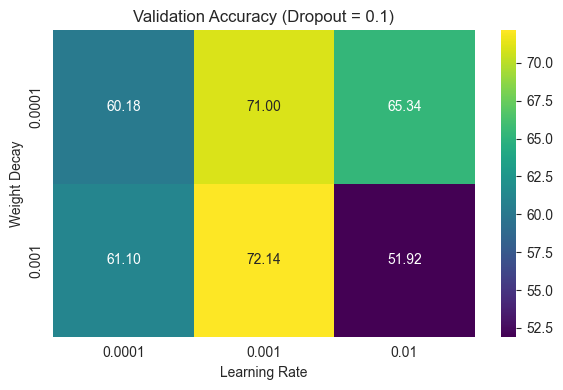

In [46]:
dropouts = sorted(df_cifar['dropout'].unique())
for dp in dropouts:
    pivot = df_cifar[df_cifar['dropout'] == dp].pivot(index='weight_decay', columns='lr', values='val_acc')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f'Validation Accuracy (Dropout = {dp})')
    plt.xlabel('Learning Rate')
    plt.ylabel('Weight Decay')
    plt.tight_layout()
    plt.show()

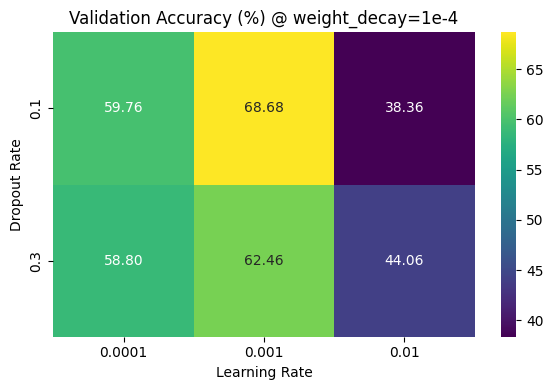

In [66]:
# 筛选 weight_decay=1e-4 的子集，再 pivot
pivot = df[df.weight_decay==1e-3].pivot(
    index='dropout',
    columns='lr',
    values='val_acc'
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("Validation Accuracy (%)  weight_decay=1e-4")
plt.xlabel("Learning Rate")
plt.ylabel("Dropout Rate")
plt.tight_layout()
plt.show()


# 对icub进行调参

In [10]:
# 超参空间
lrs   = [1e-4, 1e-3, 1e-2]
wds   = [1e-4, 1e-3]
dps   = [0.1]
all_combos = list(itertools.product(lrs, wds, dps))

results = []

for lr, wd, dp in tqdm(all_combos, desc="iCub Hyperparam Search"):
    # 1. 每次新建模型 & 优化器
    model = ImprovedCNN(dropout=dp).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=wd
    )
    criterion = nn.CrossEntropyLoss()

    # 2. 快速训练 3 个 epoch
    model.train()
    for _ in range(3):
        for inputs, labels in icub_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

    # 3. 在验证集上评估
    model.eval()
    total = correct = 0
    with torch.no_grad():
        for inputs, labels in icub_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    val_acc = correct / total * 100
    results.append({
        'lr': lr,
        'weight_decay': wd,
        'dropout': dp,
        'val_acc': val_acc
    })

# 4. 找到最优组合
best = max(results, key=lambda x: x['val_acc'])
print("All results:")
for r in sorted(results, key=lambda x: x['val_acc'], reverse=True):
    print(r)
print("\nBest hyperparameters:", best)


iCub Hyperparam Search: 100%|██████████| 6/6 [1:10:59<00:00, 709.93s/it]

All results:
{'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.1, 'val_acc': 97.4188176519567}
{'lr': 0.001, 'weight_decay': 0.001, 'dropout': 0.1, 'val_acc': 93.75520399666945}
{'lr': 0.0001, 'weight_decay': 0.001, 'dropout': 0.1, 'val_acc': 92.08992506244796}
{'lr': 0.0001, 'weight_decay': 0.0001, 'dropout': 0.1, 'val_acc': 90.59117402164863}
{'lr': 0.01, 'weight_decay': 0.001, 'dropout': 0.1, 'val_acc': 71.27393838467944}
{'lr': 0.01, 'weight_decay': 0.0001, 'dropout': 0.1, 'val_acc': 67.8601165695254}

Best hyperparameters: {'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.1, 'val_acc': 97.4188176519567}


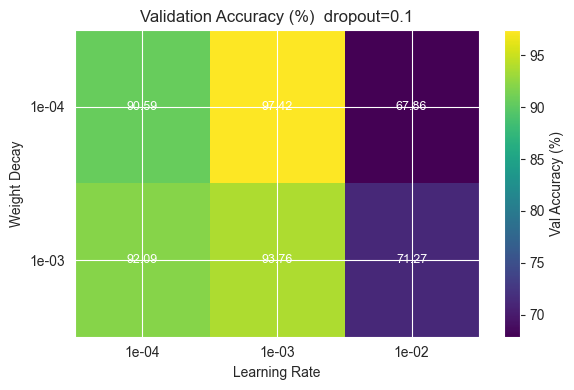

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的搜索结果已经存在 results 列表中
# results = [
#     {'lr': 1e-4, 'weight_decay': 1e-4, 'dropout': 0.1, 'val_acc': 62.5},
#     {'lr': 1e-3, 'weight_decay': 1e-4, 'dropout': 0.1, 'val_acc': 64.2},
#     # …
# ]

df = pd.DataFrame(results)

# 1. 固定一个 dropout
fixed_dp = 0.1
sub = df[df['dropout'] == fixed_dp]

# 2. 构造以 weight_decay 为行、lr 为列的 pivot table
pivot = sub.pivot(index='weight_decay', columns='lr', values='val_acc')

# 3. 绘图
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(pivot.values, cmap='viridis', aspect='auto')

# 设置坐标轴刻度和标签
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([f"{lr:.0e}" for lr in pivot.columns])
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels([f"{wd:.0e}" for wd in pivot.index])

# 在每个单元格中标注数值
for i, wd in enumerate(pivot.index):
    for j, lr in enumerate(pivot.columns):
        val = pivot.loc[wd, lr]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=9)

# 添加标题和轴标签
ax.set_title(f"Validation Accuracy (%)  dropout={fixed_dp:.1f}")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Weight Decay")

# 添加 colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Val Accuracy (%)')

plt.tight_layout()
plt.show()


# 训练icub

In [11]:
best_lr_icub = 1e-3
best_wd_icub = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_lr_icub,
    weight_decay=best_wd_icub
)

In [12]:
N_EPOCH = 10
history = train_model(N_EPOCH, icub_train_loader, icub_val_loader)

Epoch 1/10  Loss: 0.5252 Acc: 0.8313  Val Loss: 0.3171 Val Acc: 0.8959
Epoch 2/10  Loss: 0.4032 Acc: 0.8629  Val Loss: 0.2849 Val Acc: 0.9267
Epoch 3/10  Loss: 0.3406 Acc: 0.8952  Val Loss: 0.2901 Val Acc: 0.9084
Epoch 4/10  Loss: 0.3282 Acc: 0.9065  Val Loss: 0.1806 Val Acc: 0.9459
Epoch 5/10  Loss: 0.2534 Acc: 0.9258  Val Loss: 0.3021 Val Acc: 0.8651
Epoch 6/10  Loss: 0.2129 Acc: 0.9417  Val Loss: 0.1970 Val Acc: 0.9242
Epoch 7/10  Loss: 0.1883 Acc: 0.9483  Val Loss: 0.1150 Val Acc: 0.9667
Epoch 8/10  Loss: 0.2111 Acc: 0.9573  Val Loss: 0.1137 Val Acc: 0.9759
Epoch 9/10  Loss: 0.2114 Acc: 0.9479  Val Loss: 0.0772 Val Acc: 0.9867
Epoch 10/10  Loss: 0.1584 Acc: 0.9608  Val Loss: 0.0711 Val Acc: 0.9933
Training complete.


# 训练cifar10

In [30]:
# 3. 训练设置
# 1) 用最优 dropout 重建模型
best_dropout = 0.1
model = ImprovedCNN(dropout=best_dropout).to(device)

# 2) 损失函数不变
criterion = nn.CrossEntropyLoss()

# 3) 优化器用最优的 lr：1e-2 和 weight_decay:1e-4
best_lr = 1e-3
best_wd = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_lr,
    weight_decay=best_wd
)

In [31]:
# 4. 训练过程
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    # —— 训练阶段 —— #
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)

    # —— 验证阶段 —— #
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100.0 * correct / total

    # —— 汇总输出 —— #
    print(f"Epoch {epoch}/{num_epochs}  |  Loss: {avg_loss:.4f}  |  Val Acc: {val_acc:.2f}%")


Epoch 1/10  |  Loss: 1.3408  |  Val Acc: 55.24%
Epoch 2/10  |  Loss: 0.9758  |  Val Acc: 59.86%
Epoch 3/10  |  Loss: 0.8218  |  Val Acc: 70.28%
Epoch 4/10  |  Loss: 0.7273  |  Val Acc: 72.70%
Epoch 5/10  |  Loss: 0.6545  |  Val Acc: 71.96%
Epoch 6/10  |  Loss: 0.6145  |  Val Acc: 75.94%
Epoch 7/10  |  Loss: 0.5784  |  Val Acc: 77.12%
Epoch 8/10  |  Loss: 0.5463  |  Val Acc: 80.70%
Epoch 9/10  |  Loss: 0.5210  |  Val Acc: 76.58%
Epoch 10/10  |  Loss: 0.5033  |  Val Acc: 79.88%


# cifar 测试集

In [32]:
# 5. 测试集评估
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 79.88%


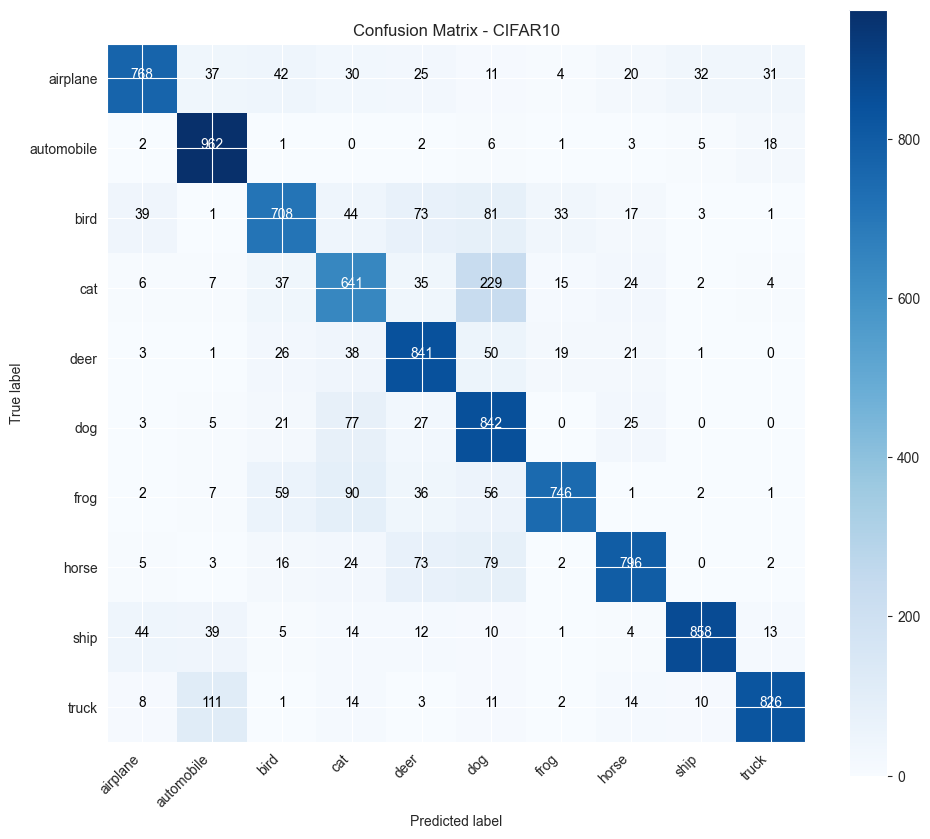

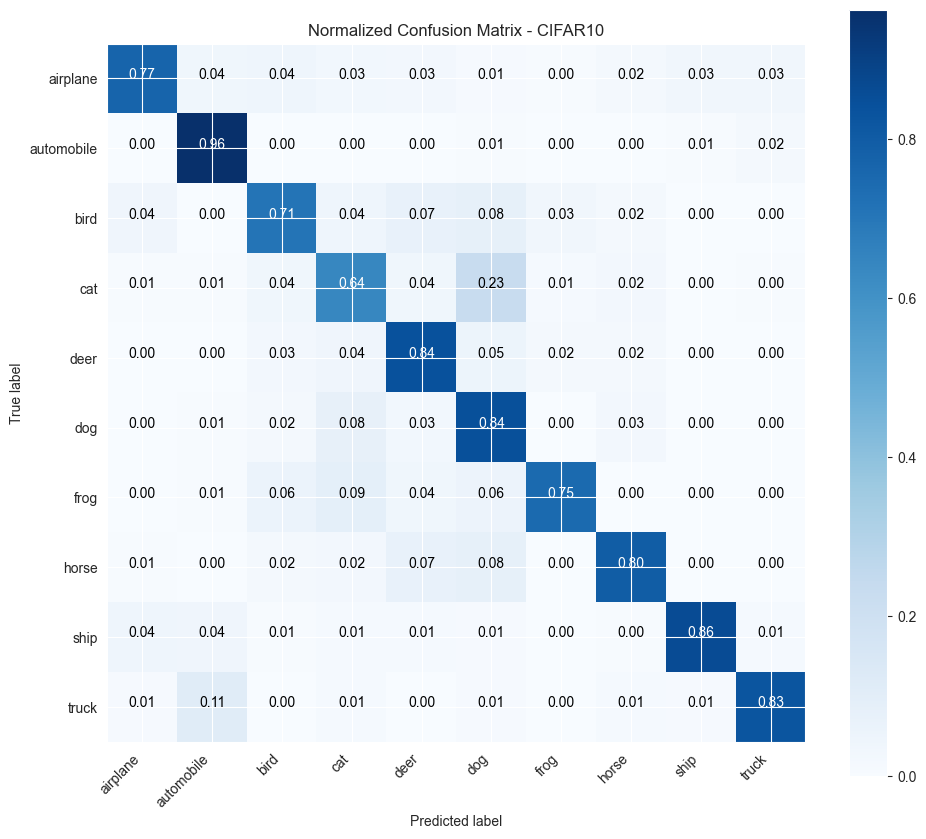

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)

# 3. 可视化函数
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    cm: 混淆矩阵数组
    classes: 类别名称列表
    normalize: 是否归一化
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# 4. 画图
classes = testset.classes  # CIFAR-10 的类别名称
plot_confusion_matrix(cm, classes, normalize=False,
                      title='Confusion Matrix - CIFAR10')
plt.show()

# 如果想看归一化结果：
plot_confusion_matrix(cm, classes, normalize=True,
                      title='Normalized Confusion Matrix - CIFAR10')
plt.show()

In [57]:
# 你的类别名称列表
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [73]:

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
  for inputs, labels in testloader:
    inputs = inputs.to(device)
    out    = model(inputs)
    preds  = out.argmax(dim=1).cpu().numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())


# 2a) Should equal your simple loop:
print("accuracy_score:", accuracy_score(y_true, y_pred)*100)

# 2b) classification_report 的“accuracy”行也应该一致
print(classification_report(y_true, y_pred,
                            target_names=cifar10_classes))

accuracy_score: 78.66
              precision    recall  f1-score   support

    airplane       0.82      0.81      0.82      1000
  automobile       0.94      0.87      0.91      1000
        bird       0.53      0.90      0.67      1000
         cat       0.63      0.70      0.67      1000
        deer       0.97      0.50      0.66      1000
         dog       0.85      0.60      0.71      1000
        frog       0.85      0.87      0.86      1000
       horse       0.91      0.76      0.83      1000
        ship       0.88      0.90      0.89      1000
       truck       0.81      0.94      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.82      0.79      0.79     10000
weighted avg       0.82      0.79      0.79     10000



# icub测试集

In [13]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. 在测试集上做预测
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in icub_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)



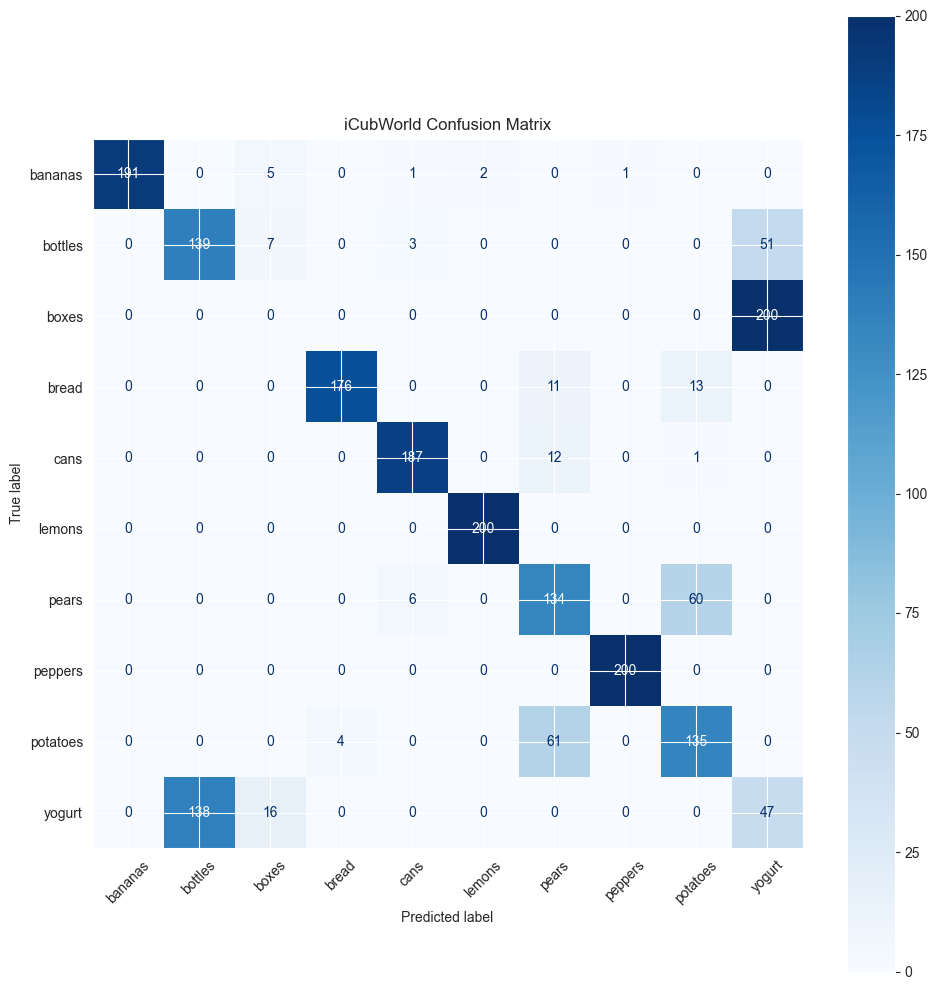

Test Accuracy: 70.41%


In [47]:
# 2. 计算混淆矩阵
# 确保 class_names 对应 icub_train_ds.dataset.classes
class_names = icub_train_ds.dataset.classes  
cm = confusion_matrix(y_true, y_pred)

# 3. 可视化
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
ax.set_title("iCubWorld Confusion Matrix")
plt.tight_layout()
plt.show()

# 4. 打印 overall accuracy
acc = (y_true == y_pred).sum() / len(y_true)
print(f"Test Accuracy: {acc*100:.2f}%")


/Users/jinzi/Coding/PycharmProject/clinicalBERT/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinzi/Coding/PycharmProject/clinicalBERT/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinzi/Coding/PycharmProject/clinicalBERT/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinzi/Coding/PycharmProject/clinicalBERT/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinzi/Coding/PycharmP

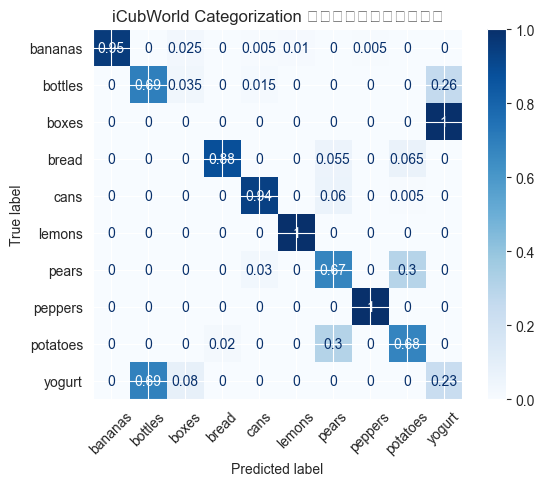

In [15]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=class_names,
    cmap='Blues',
    normalize='true',         # 按行归一化，看到的是每行预测的百分比
    xticks_rotation=45
)
plt.title("iCubWorld Categorization 混淆矩阵（按行归一化）")
plt.show()
